In [1]:
import pyddm
import numpy as np
import random
import pandas as pd
from riskyneuroarousal.utils.ddm_sample_generator import (get_ddm_model_2, 
                                                          get_model_samples)
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
drift = 0.06981909179687501
c = -0.07236474609375
alpha = 1.399974609375
lambd= 1.1876859130859374
bound = 2.5499426269531247
theta = 0.6515035400390625
x0 = 0.1028212890625
nondectime = 0.3040329924795568

In [3]:
model = get_ddm_model_2(x0=x0, 
                        drift=drift, 
                        c = c, 
                        alpha = alpha,
                        lambd = lambd,
                        bound = bound,
                        theta = theta,
                        nondecision=nondectime,)

In [4]:
def get_trials(gains, losses, repetitions = 1):
    trials = []
    for g in gains:
        for l in losses:
            trials += [{"gain": g, "loss": l}] * repetitions
    
    random.shuffle(trials)
    return pd.DataFrame(trials)

In [5]:
gains = np.arange(5, 21, 1)
gains2 = np.arange(10, 41, 2)
losses = np.arange(5, 21, 1)
trials = get_trials(gains2, losses, repetitions=1)

In [6]:
trials["sub"] = 1
trials["condition"] = 'equalIndifference'

In [7]:
sim = get_model_samples(trials, model, samples_per_condition=50)

<Axes: xlabel='RT', ylabel='Count'>

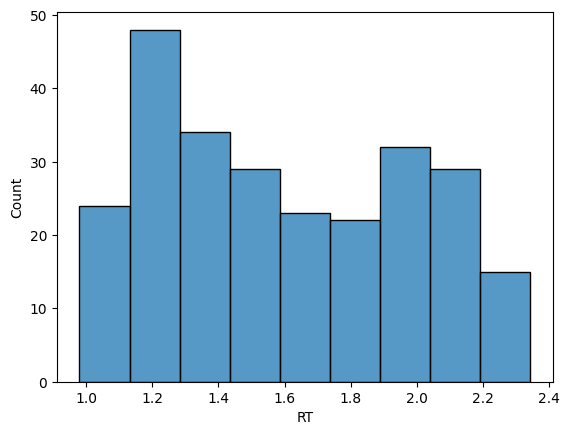

In [8]:
sns.histplot(data=sim, x="RT")

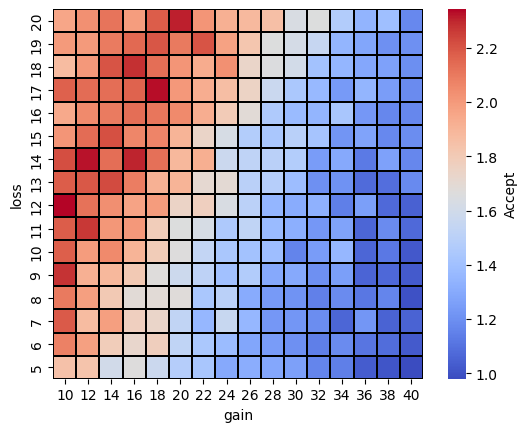

In [10]:
hmap_data = sim.groupby(['loss', 'gain'])['RT'].mean().unstack()
# Reverse the order of gain
hmap_data = hmap_data.iloc[::-1]
ax = sns.heatmap(hmap_data, cmap='coolwarm', cbar_kws={'label': 'Accept'}, square=True, linewidths=0.2, linecolor='black', cbar = True)

##### Comparison model DDM with SVs

In [110]:
x = pd.read_csv('ddm_parameters6.csv').query("sub != 56").reset_index(drop=True)

In [113]:
BIC = x.query("param_name == 'BIC'").reset_index()

In [114]:
idx = BIC.groupby('sub')['mean'].idxmin()

In [115]:
best_models = BIC.loc[idx].reset_index(drop=True)


/var/folders/xd/6fbjp5ms7ss8c4xxlmz91xkm0000gn/T/ipykernel_79176/3232579311.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=model_counts, x='model', y='count', palette='viridis')


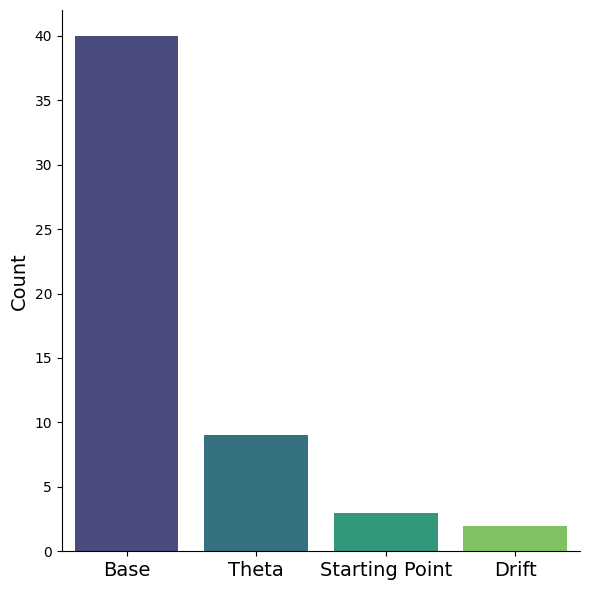

In [125]:
model_counts = best_models['model'].value_counts().reset_index()
model_counts.columns = ['model', 'count']

# Plot
plt.figure(figsize=(6, 6))
sns.barplot(data=model_counts, x='model', y='count', palette='viridis')
plt.xlabel('', fontsize=14)
plt.xticks(fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.tight_layout()
sns.despine()
plt.xticks([0, 1, 2, 3], ['Base', 'Theta', 'Starting Point', 'Drift'])

plt.show()

In [70]:
starting_point = x.query("param_name == 'z' & model == 'normal'")

In [89]:
pupil = pd.read_csv('hddm_pupil_data.csv').query("sub != 4")

In [90]:
accept_reject_pupil = pupil.groupby(["sub", "accept"])["pupil_size"].mean().reset_index()

In [92]:
accept_minus_reject = accept_reject_pupil.query("accept == 1")["pupil_size"].values - accept_reject_pupil.query("accept == 0")["pupil_size"].values

In [93]:
starting_point = starting_point.sort_values(by=["sub"])

In [95]:
starting_point["accept_minus_reject"] = accept_minus_reject

In [98]:
starting_point["condition"] = starting_point["sub"].apply(lambda x: "equalIndifference" if x%2 == 1 else "equalRange")

In [100]:
svs = pd.read_csv('behavioral_data_SVs.csv')
mean_accept = svs.groupby(['sub', 'condition'])[['accept']].mean().reset_index().rename(columns={'accept': 'mean_accept'})


In [102]:
starting_point = starting_point.merge(mean_accept, on=["sub", "condition"], how="left")

<Axes: xlabel='mean', ylabel='accept_minus_reject'>

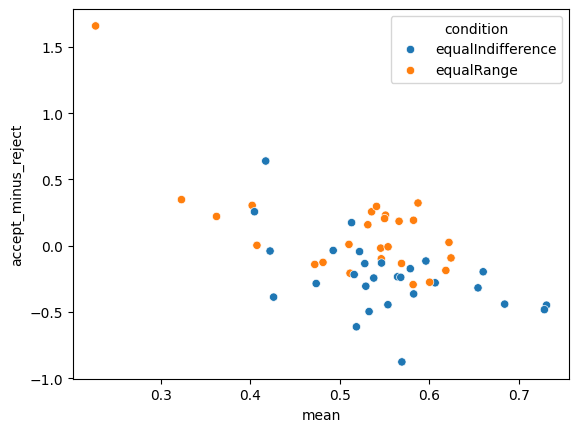

In [ ]:
sns.scatterplot(data = starting_point, x = "mean", y = "accept_minus_reject", hue = "condition")

(-1.0, 0.75)

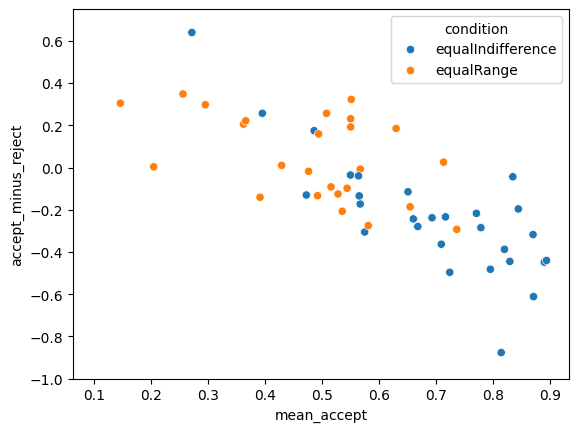

In [ ]:
sns.scatterplot(data = starting_point, x = "mean_accept", y = "accept_minus_reject", hue = "condition")
plt.ylim(-1, 0.75)

# So why pupil dilate more when you do the thing you dont commonly do?
# And what does that mean?
# Can we create a covariate of some sort? like proportion below?
# Statistics of the SV?


In [21]:
x["condition"] = x["sub"].apply(lambda x: "equalRange" if x % 2 == 0 else "equalIndifference")

In [48]:
# sort x by sub
x = x.sort_values(by=["sub"])

In [63]:
palette[0]

(0.4, 0.7607843137254902, 0.6470588235294118)

/var/folders/xd/6fbjp5ms7ss8c4xxlmz91xkm0000gn/T/ipykernel_79176/497001945.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x.query(f"param_name == 'BIC'"), x = "model", y = "mean", palette = [palette[0], palette[1], palette[2], palette[3]])


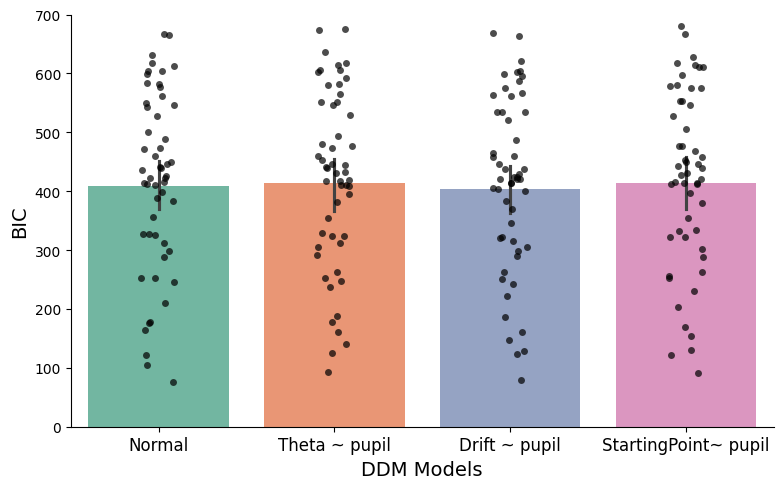

In [67]:
# Palette that works without hue
palette = sns.color_palette("Set2", 4)
palette[0] = "#66c2a5"
palette[1] = "#fc8d62"
palette[2] = "#8da0cb"
palette[3] = "#e78ac3"
fig = plt.figure(figsize=(8, 5))
ax= sns.stripplot(x.query(f"param_name == 'BIC' "), x = "model", y = "mean", dodge=True, alpha=0.7, color = "black")
sns.barplot(x.query(f"param_name == 'BIC'"), x = "model", y = "mean", palette = [palette[0], palette[1], palette[2], palette[3]])

plt.ylim(0, 700)
sns.despine()
plt.xlabel("DDM Models", fontsize=14)
plt.xticks([0, 1, 2, 3], ["Normal", "Theta ~ pupil", "Drift ~ pupil", "StartingPoint~ pupil"], fontsize=12)
plt.ylabel("BIC", fontsize=14)
plt.tight_layout()

In [54]:
# ttest relative normal to all models
from scipy import stats

t_stat, p_val = stats.ttest_rel(x.query(f"param_name == 'BIC' & model == 'normal'")["mean"].values, 
                                 x.query(f"param_name == 'BIC' & model == 'driftbias'")["mean"].values,)
print("Normal vs Drift ~ pupil")
print(f"t_stat: {t_stat}, p_val: {p_val}")

t_stat, p_val = stats.ttest_rel(x.query(f"param_name == 'BIC' & model == 'normal'")["mean"].values,
                                 x.query(f"param_name == 'BIC' & model == 'startingpoint'")["mean"].values,)
print("Normal vs StartingPoint ~ pupil")
print(f"t_stat: {t_stat}, p_val: {p_val}")

t_stat, p_val = stats.ttest_rel(x.query(f"param_name == 'BIC' & model == 'normal'")["mean"].values,
                                 x.query(f"param_name == 'BIC' & model == 'theta'")["mean"].values,)
print("Normal vs Theta ~ pupil")
print(f"t_stat: {t_stat}, p_val: {p_val}")


Normal vs Drift ~ pupil
t_stat: -11.379224792037986, p_val: 7.581586658651842e-16
Normal vs StartingPoint ~ pupil
t_stat: -11.59957638261386, p_val: 3.6518190711034975e-16
Normal vs Theta ~ pupil
t_stat: -5.308866393149748, p_val: 2.218361146529445e-06


(350.0, 450.0)

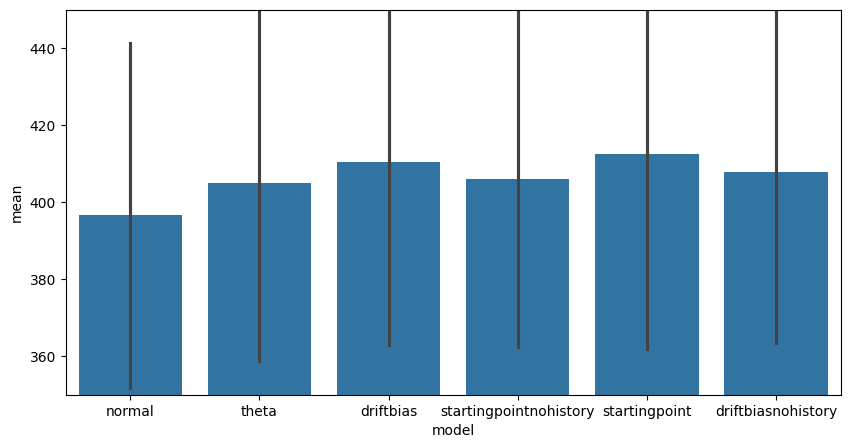

In [74]:
fig = plt.figure(figsize=(10, 5))
sns.barplot(x.query(f"param_name == 'BIC'"), x = "model", y = "mean")
plt.ylim(350, 450)

In [82]:
x1['param_name'] = x1['param_name'].str.replace(
    r'^v_C\(pupil_bin\)\[(Low|Medium|High)\].*$',
    lambda m: m.group(1).lower(),
    regex=True
)

In [84]:
x2 = x1.query("param_name in ['low', 'medium', 'high']").reset_index(drop=True)
x2['condition'] = np.where(x2['sub'] % 2 == 0, 'equalRange', 'equalIndifference')

In [104]:
svs = pd.read_csv('behavioral_data_SVs.csv')
mean_accept = svs.groupby(['sub', 'condition'])[['accept']].mean().reset_index().rename(columns={'accept': 'mean_accept'})


In [ ]:
svs = pd.read_csv('behavioral_data_SVs.csv')
mean_accept = svs.groupby(['sub', 'condition'])[['accept']].mean().reset_index().rename(columns={'accept': 'mean_accept'})

conditions = [
    mean_accept['mean_accept'] < 0.4,
    mean_accept['mean_accept'] > 0.6,
    (mean_accept['mean_accept'] >= 0.4) & (mean_accept['mean_accept'] <= 0.60)
]
# Define corresponding choices
choices = ['risk_averse', 'risk_prefered', 'neutral']

# Create new column
mean_accept['risk_profile'] = np.select(conditions, choices, default='unknown')

In [107]:
x1 = x1.merge(mean_accept[['sub', 'risk_profile']], on=['sub'], how='left')

In [108]:
risk_profile_counts = x1['risk_profile'].value_counts()
risk_profile_counts

risk_profile
risk_prefered    184
neutral          176
risk_averse       72
Name: count, dtype: int64

<Axes: xlabel='risk_profile', ylabel='mean'>

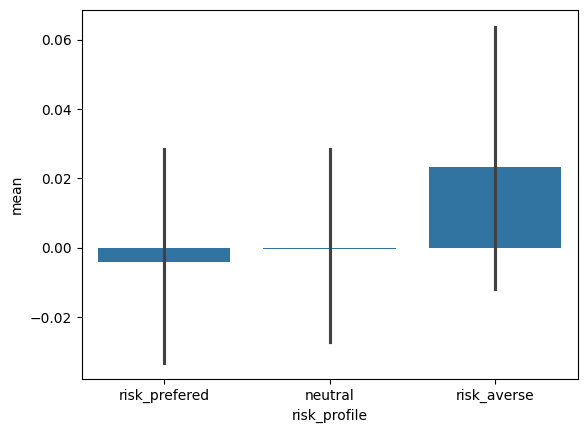

In [109]:
# # bar plot ordered low, medium, high
# x2['param_name'] = pd.Categorical(x2['param_name'], categories=['low', 'medium', 'high'], ordered=True)
# x2['mean'] = x2['mean'].astype(float)
sns.barplot(x1.query("param_name == 'v_pupil_size'"), x='risk_profile', y='mean')


In [ ]:
print("High", x1.query("param_name == 'v_C(pupil_bin)[High]:dir_opposite_prev_response'")['mean'].mean())
print("Medium", x1.query("param_name == 'v_C(pupil_bin)[Medium]:dir_opposite_prev_response'")['mean'].mean())
print("Low", x1.query("param_name == 'v_C(pupil_bin)[Low]:dir_opposite_prev_response'")['mean'].mean())

High -0.014017436905450362
Medium -0.03309673986007865
Low -0.04309025560079446


In [111]:
x1

,Unnamed: 0,param_name,mean,std,2.5q,25q,50q,75q,97.5q,mc err,sub,model,condition
0,20,a,1.923832,0.180861,1.616264,1.799909,1.907160,2.029659,2.317678,0.011134,109,ddm2.csv,equalIndifference
1,21,z,0.420678,0.014802,0.391327,0.410654,0.420839,0.430791,0.449368,0.000193,109,ddm2.csv,equalIndifference
2,22,t,0.576779,0.064813,0.431674,0.540185,0.582950,0.621875,0.682320,0.003781,109,ddm2.csv,equalIndifference
3,23,theta,0.451180,0.060128,0.332523,0.411509,0.450589,0.490558,0.567605,0.003438,109,ddm2.csv,equalIndifference
4,27,v_decision_value_norm,2.882347,0.111356,2.639448,2.814705,2.889470,2.958208,3.081734,0.003007,109,ddm2.csv,equalIndifference
...,...,...,...,...,...,...,...,...,...,...,...,...,...
265,1007,a,1.553737,0.132420,1.338795,1.463868,1.537427,1.625253,1.874692,0.006910,85,ddm2.csv,equalIndifference
266,1008,z,0.555666,0.018235,0.519868,0.543382,0.555957,0.568173,0.590869,0.000385,85,ddm2.csv,equalIndifference
267,1009,t,0.559806,0.041824,0.458668,0.536410,0.564899,0.588830,0.626268,0.002038,85,ddm2.csv,equalIndifference
268,1010,theta,0.400484,0.069617,0.278905,0.355116,0.394074,0.438387,0.561218,0.003313,85,ddm2.csv,equalIndifference


In [32]:
import matplotlib.pyplot as plt
from scipy.stats import false_discovery_control
import scipy.stats as stats

In [48]:
# Rename terms in column param_names that start with "v*" to "v"
x['param_name'] = x['param_name'].str.replace(r'^v_.*', 'v', regex=True)

In [51]:
# new column that is condition. equalIndifference if sub is odd, equalRange if sub is even
x['condition'] = np.where(x['sub'] % 2 == 0, 'equalRange', 'equalIndifference')

In [7]:
x

,Unnamed: 0,param_name,mean,std,2.5q,25q,50q,75q,97.5q,mc err,sub,model
0,0,a,2.614445,0.246320,2.090972,2.449238,2.637686,2.816150,2.982383,0.015676,47,normal
1,1,z,0.518585,0.038869,0.441159,0.492792,0.519313,0.545164,0.591339,0.001572,47,normal
2,2,t,0.857776,0.097510,0.678324,0.787674,0.854559,0.924469,1.050369,0.005783,47,normal
3,3,theta,0.632470,0.062108,0.486394,0.595714,0.641203,0.679640,0.726629,0.003578,47,normal
4,4,v_Intercept,0.313640,0.138514,0.042624,0.223002,0.313039,0.408388,0.578796,0.005373,47,normal
...,...,...,...,...,...,...,...,...,...,...,...,...
859,859,v_Intercept,-0.367386,0.155810,-0.663565,-0.475550,-0.368208,-0.254714,-0.077236,0.010805,33,driftbias
860,860,v_C(pupil_bin)[T.Low],0.154087,0.146863,-0.121776,0.056023,0.146639,0.249103,0.457780,0.007080,33,driftbias
861,861,v_C(pupil_bin)[T.Medium],-0.216778,0.139217,-0.442488,-0.318343,-0.230371,-0.129073,0.091397,0.007902,33,driftbias
862,862,v_subj_value_norm,3.517060,0.159762,3.195701,3.411286,3.520653,3.635582,3.799197,0.010130,33,driftbias


In [10]:
x["condition"] = x["sub"].apply(lambda x: "equalRange" if x % 2 == 0 else "equalIndifference")

Text(0, 0.5, 'Mean Estimate')

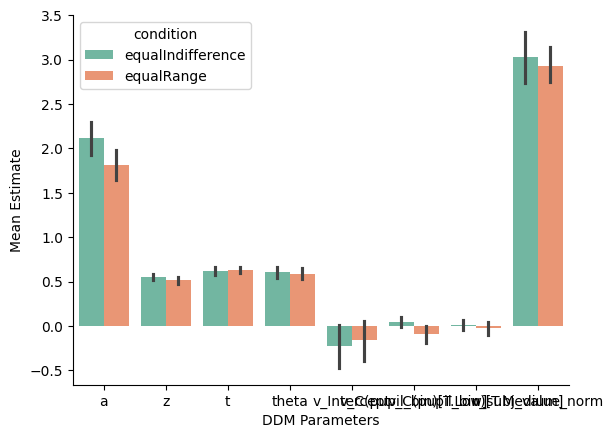

In [12]:
sns.barplot(data=x.query("param_name != 'BIC' & model == 'driftbias'"), x='param_name', y='mean', hue = "condition", palette='Set2')
sns.despine()
plt.xlabel('DDM Parameters')
plt.ylabel('Mean Estimate')

In [38]:
p_values = []
t_stats = []
names = []
for i in range(4):
    for j in range(4):
        if i > j:
            model1 = x["model_SV"].unique()[i]
            model2 = x["model_SV"].unique()[j]
            data1 = x.query(f"param_name == 'BIC' & model_SV == '{model1}'").sort_values(by='sub')["mean"]
            data2 = x.query(f"param_name == 'BIC' & model_SV == '{model2}'").sort_values(by='sub')["mean"]
            t_stat, p_val = stats.ttest_rel(data1, data2)
            p_values.append(p_val)
            t_stats.append(t_stat)
            names.append(f"{model1} vs {model2}")

p_values = false_discovery_control(p_values, method = "by")
for i, name in enumerate(names):
    if p_values[i] < 0.05:
        print(f"Significant difference between {name} with p-value: {p_values[i]} and t-stat: {t_stats[i]}")

Significant difference between CPT_ordinal vs EV_ordinal with p-value: 0.0003157074876477172 and t-stat: -4.268637898917416
Significant difference between CPT_ordinal vs EV_binary with p-value: 0.0003157074876477172 and t-stat: -4.330604213045288


(375.0, 450.0)

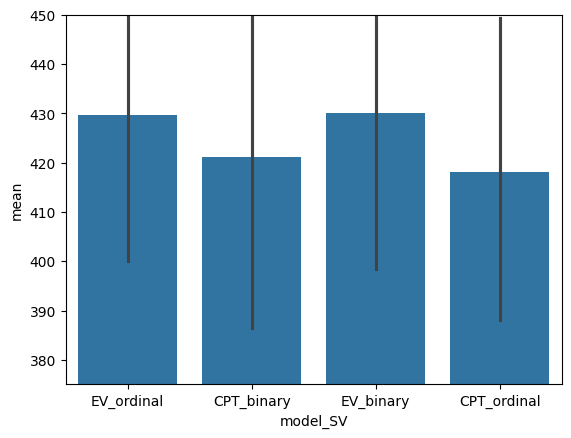

In [ ]:
sns.barplot(data=x.query("param_name == 'BIC'"), x = 'model_SV', y = 'mean')
plt.ylim(375, 450)